In [3]:
import torch
from torch import nn
from d2l import torch as d2l

/home/tian/anaconda3/envs/d2l/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [4]:
batch_size, max_len = 512, 64
train_iter, vocab = d2l.load_data_wiki(batch_size, max_len)

# Pretraining BERT

 a small BERT, using 2 layers, 128 hidden units, and 2 self-attention heads.

In [7]:
net = d2l.BERTModel(len(vocab), num_hiddens=128,
                    ffn_num_hiddens=256, num_heads=4, num_blks=2, dropout=0.2)
devices = d2l.try_all_gpus()
loss = nn.CrossEntropyLoss()

/home/tian/anaconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [12]:
a = next(iter(train_iter))
a[0]

tensor([[  942,  9515,   943,  ...,   944,   944,   944],
        [  942, 18282, 17062,  ...,   944,   944,   944],
        [  942,   943,  8838,  ...,   944,   944,   944],
        ...,
        [  942,   998,   198,  ...,   944,   944,   944],
        [  942,  2951, 10504,  ...,   944,   944,   944],
        [  942,  9515, 18282,  ...,   944,   944,   944]])

Loss func.

In [15]:
# this function computes the loss for both the masked language modeling and next sentence prediction tasks.
# final loss = masked language modeling loss + next sentence prediction loss
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X,
                         segments_X, valid_lens_x,
                         pred_positions_X, mlm_weights_X,
                         mlm_Y, nsp_y):
    # Forward pass
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X,
                                  valid_lens_x.reshape(-1),
                                  pred_positions_X)
    # Compute masked language model loss
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) * mlm_weights_X.reshape(-1, 1)
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    # Compute next sentence prediction loss
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l

Training loop

MLM loss 5.060, NSP loss 0.712
8403.8 sentence pairs/sec on [device(type='cuda', index=0)]


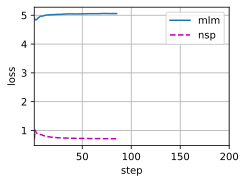

In [23]:
#  Training BERT can take very long. Instead of specifying the number of epochs for training as in the train_ch13 function 
# (see Section 14.1), the input num_steps of the following function specifies the number of iteration steps for training.

vocab_size = len(vocab)
num_steps = 200

net(*next(iter(train_iter))[:4])

net = nn.DataParallel(net, device_ids=devices).to(devices[0])
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
step, timer = 0, d2l.Timer()
animator = d2l.Animator(xlabel='step', ylabel='loss', xlim=[1, num_steps], legend=['mlm', 'nsp'])
# Sum of masked language modeling losses, sum of next sentence prediction
# losses, no. of sentence pairs, count
metric = d2l.Accumulator(4)
num_steps_reached = False
step = 0
for tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X, mlm_Y, nsp_y in train_iter:
    tokens_X = tokens_X.to(devices[0])
    segments_X = segments_X.to(devices[0])
    valid_lens_x = valid_lens_x.to(devices[0])
    pred_positions_X = pred_positions_X.to(devices[0])
    mlm_weights_X = mlm_weights_X.to(devices[0])
    mlm_Y, nsp_y = mlm_Y.to(devices[0]), nsp_y.to(devices[0])

    timer.start()

    mlm_l, nsp_l, l = _get_batch_loss_bert(net, loss, vocab_size, tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)

    optimizer.zero_grad()
    l.backward()
    optimizer.step()

    metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
    timer.stop()

    animator.add(step + 1, (metric[0] / metric[3], metric[1] / metric[3]))
    step += 1
    if step == num_steps:
        num_steps_reached = True
        break

print(f'MLM loss {metric[0] / metric[3]:.3f}, 'f'NSP loss {metric[1] / metric[3]:.3f}')
print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on 'f'{str(devices)}')

# Representing Text with BERT

In [33]:
net.eval()

DataParallel(
  (module): DataParallel(
    (module): DataParallel(
      (module): DataParallel(
        (module): BERTModel(
          (encoder): BERTEncoder(
            (token_embedding): Embedding(20256, 128)
            (segment_embedding): Embedding(2, 128)
            (blks): Sequential(
              (0): TransformerEncoderBlock(
                (attention): MultiHeadAttention(
                  (attention): DotProductAttention(
                    (dropout): Dropout(p=0.2, inplace=False)
                  )
                  (W_q): Linear(in_features=128, out_features=128, bias=True)
                  (W_k): Linear(in_features=128, out_features=128, bias=True)
                  (W_v): Linear(in_features=128, out_features=128, bias=True)
                  (W_o): Linear(in_features=128, out_features=128, bias=True)
                )
                (addnorm1): AddNorm(
                  (dropout): Dropout(p=0.2, inplace=False)
                  (ln): LayerNorm((128,), eps=1e-05

In [85]:
def get_bert_encoding(net, tokens_a, tokens_b=None, pred_pos=None):
    tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
    token_ids = torch.tensor(vocab[tokens], device=devices[0]).unsqueeze(0)
    segments = torch.tensor(segments, device=devices[0]).unsqueeze(0)
    valid_len = torch.tensor(len(tokens), device=devices[0]).unsqueeze(0)
    encoded_X, mlm_result, nsp_result = net(token_ids, segments, valid_len, pred_pos)
    return encoded_X, mlm_result, nsp_result

In [39]:
tokens_a = ['a', 'crane', 'is', 'flying']
encoded_text, mlm_result, nsp_result = get_bert_encoding(net, tokens_a)
# Tokens: '<cls>', 'a', 'crane', 'is', 'flying', '<sep>'
encoded_text_cls = encoded_text[:, 0, :]
encoded_text_crane = encoded_text[:, 2, :]
encoded_text.shape, encoded_text_cls.shape, encoded_text_crane[0][:3]

(torch.Size([1, 6, 128]),
 torch.Size([1, 128]),
 tensor([0.0570, 0.0610, 0.7910], device='cuda:0', grad_fn=<SliceBackward0>))

In [131]:
a = 'The Tower Building of the Little Rock Arsenal'
b = None
a = a.lower().split(" ")
# b = b.lower().split(" ")

In [139]:
tokens_a, tokens_b = a, b
encoded_pair,mlm_result, nsp_result = get_bert_encoding(net, tokens_a, tokens_b, torch.tensor([[3, 5]]))
encoded_pair_cls = encoded_pair[:, 0, :]
encoded_pair_crane = encoded_pair[:, 2, :]
encoded_pair.shape, encoded_pair_cls.shape, encoded_pair_crane[0][:3], mlm_result

(torch.Size([1, 10, 128]),
 torch.Size([1, 128]),
 tensor([-0.0286, -0.1263,  1.0325], device='cuda:0', grad_fn=<SliceBackward0>),
 tensor([[[  6.9897,   3.6063,  -3.3368,  ..., -11.5575, -11.8362,  -7.5417],
          [  6.9893,   3.6063,  -3.3365,  ..., -11.5576, -11.8361,  -7.5411]]],
        device='cuda:0', grad_fn=<ViewBackward0>))

In [140]:
mlm_result.shape

torch.Size([1, 2, 20256])

In [149]:
masked_word = torch.argmax(torch.softmax(mlm_result, 2), 2)
masked_word

tensor([[0, 0]], device='cuda:0')

In [138]:
vocab.idx_to_token[0]

'!'

In [61]:
_, if_nsp = torch.max(torch.softmax(nsp_result, 1), 1)
if_nsp

tensor([0], device='cuda:0')